* To calculate v velocity of the drifter, in order to compare the values with modelled results.

In [1]:
%matplotlib inline
from matplotlib import pylab
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import scipy.io
import datetime as dt
import drifter
from salishsea_tools import nc_tools, viz_tools, tidetools, stormtools, bathy_tools

from __future__ import division

In [2]:
drifters = scipy.io.loadmat('/ocean/mhalvers/research/drifters/SoG_drifters.mat',squeeze_me=True)
ubc = drifters['ubc']

In [3]:
grid = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea6.nc','r')
bathy = grid.variables['Bathymetry'][:, :]
X = grid.variables['nav_lon'][:, :]
Y = grid.variables['nav_lat'][:, :]

In [4]:
tracersT = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/oct8_10RFdailySmoo/\
SalishSea_1h_20141008_20141010_grid_T.nc')
ssh = tracersT.variables['sossheig']
timesteps = tracersT.variables['time_counter']
t_t = nc_tools.timestamp(tracersT, np.arange(len(timesteps)))
for ind in range(len(t_t)):
    t_t[ind] = t_t[ind].datetime
tt = np.array(t_t) 

In [5]:
def plot_buoy(tracks, startdate, i=0, fancy=False):
    """ plots a buoy trajectory at the given startdate in an axis, ax.
    returns the trajectory that was plotted.
    The first track released on the startdate is plotted.
    For trajectories that were released mulitples times a day, i selects which release is plotted.
    """
    
    ind =drifter.find_start(tracks,startdate)
    traj=tracks[ind[i]]
    duration = (traj['time'][-1]-traj['time'][0]).total_seconds()/3600
    print ('Released', traj['time'][0], 'at', traj['lat'][0], ',' , traj['lon'][0], 'for' , duration, 'hours')
    
    [j,i]=tidetools.find_closest_model_point(float(traj['lon'][0]),float(traj['lat'][0]),X,Y,bathy,\
                lon_tol=0.0052,lat_tol=0.00210, allow_land=False)
    print ('NEMO coords:', j,i)
    return traj

# Method 1: Looking at the latitude

In [6]:
def find_y_dist(traj,k1,k2):
    """This function was made to find the y direction distance, and 
    time between the most north and most south positions"""
    ys = {}; xs = {};times = {}; cs = ['y','g']; direc = ['south','north']
    ys['south'] = min(traj['lat'][k1:(-1-k2)])
    ys['north'] = max(traj['lat'][k1:(-1-k2)])
    xs['south'] = traj['lon'][traj['lat'].index(ys['south'])]
    xs['north'] = traj['lon'][traj['lat'].index(ys['north'])]
    times['south']=traj['time'][traj['lat'].index(ys['south'])]
    times['north']=traj['time'][traj['lat'].index(ys['north'])]
    ##plot them to check
    fig, axs = plt.subplots(1,2,figsize = (15,6))
    ax = axs[0]
    ax.plot(traj['lon'],traj['lat'],'ob')
    ax.plot(traj['lon'][0],traj['lat'][0],'sr')
    ax.plot(-123-np.array([18.2, 13.7, 12])/60.,49+np.array([6.4, 8, 7.6])/60.,'-k',lw=2); 
    ## plot south, north position
    for di, c in zip(direc, cs):
        ax.plot(xs[di],ys[di],color = c, marker = 'o',label = di)   
    viz_tools.plot_coastline(ax, grid, coords='map')
    viz_tools.plot_coastline(ax, grid, coords='map',isobath=4)
    viz_tools.plot_coastline(ax, grid, coords='map',isobath=20)
    ax.set_xlim([-123.6,-123])
    ax.set_ylim([48.8,49.4])
    ax.set_xticks([-123.6, -123.4, -123.2,-123])
    ax.set_xticklabels([-123.6, -123.4, -123.2,-123])
    ax.legend()
    ax = axs[1]
    ax.plot(tt[0:48],ssh[0:48,466,329],'-k')
    for di, c in zip(direc,cs):
        ax.plot([times[di],times[di]],[-2.0,1.5],color = c,marker ='*',label=di)
    ax.legend()
    return fig, xs,ys, times

In [7]:
def Vvelocity(ys, times):
    v = (ys['north']-ys['south'])*111000*np.cos(ys['north']*np.pi/180)*100/\
    (times['north']-times['south']).total_seconds()
    print ('V velocity is', v, ' cm/s')
    ##unit cm/s
    return v

# Method 2: Looking at the mesh grid

In [8]:
def find_y_dist2(traj,k1,k2):
    jind = []; iind = []; ys={};xs={};times={};
    cs = ['y','g']; direc = ['south','north']
    if k2 == -1:
        for j, i in zip(traj['lat'][k1:],traj['lon'][k1:]):
            [jj,ii] = tidetools.find_closest_model_point(i,j,X,Y,bathy)
            jind.append(jj)
            iind.append(ii) 
    else:
        for j, i in zip(traj['lat'][k1:(-1-k2)],traj['lon'][k1:(-1-k2)]):
            [jj,ii] = tidetools.find_closest_model_point(i,j,X,Y,bathy)
            jind.append(jj)
            iind.append(ii)
    ## find the north most and south most along-shore grid point
    ys['south'] = min(jind)
    ys['north'] = max(jind)
    xs['south'] = iind[jind.index(ys['south'])]
    xs['north'] = iind[jind.index(ys['north'])]
    times['south']=traj['time'][jind.index(ys['south'])]
    times['north']=traj['time'][jind.index(ys['north'])]
    ## plot original drifter track, by using closest model point's track and water level
    fig, axs = plt.subplots(1,3,figsize = (20,6))
    ax = axs[0]
    ax.plot(traj['lon'],traj['lat'],'ob')
    ax.plot(traj['lon'][0],traj['lat'][0],'sr')
    ax.plot(-123-np.array([18.2, 13.7, 12])/60.,49+np.array([6.4, 8, 7.6])/60.,'-k',lw=2); 
    for di, c in zip(direc, cs):
        ax.plot(X[ys[di],xs[di]],Y[ys[di],xs[di]],color = c, marker = 'o',label = di)   
    ax.legend()
    ax = axs[1]
    for j, i in zip(jind, iind):
        ax.plot(X[j, i],Y[j, i],'ob')
    for ax in [axs[0],axs[1]]:
        viz_tools.plot_coastline(ax, grid, coords='map')
        viz_tools.plot_coastline(ax, grid, coords='map',isobath=4)
        viz_tools.plot_coastline(ax, grid, coords='map',isobath=20)
        ax.set_xlim([-123.6,-123])
        ax.set_ylim([48.8,49.4])
        ax.set_xticks([-123.6, -123.4, -123.2,-123])
        ax.set_xticklabels([-123.6, -123.4, -123.2,-123])
        
    ax = axs[2]
    ax.plot(tt[0:48],ssh[0:48,466,329],'-k')
    for di, c in zip(direc,cs):
        ax.plot([times[di],times[di]],[-2.0,1.5],color = c,marker ='*',label=di)
    ax.legend()
    return fig, xs,ys, times

In [9]:
def Vvelocity2(xs, ys, times):
    
    dist = tidetools.haversine(X[ys['north'], xs['north']], Y[ys['north'], xs['north']],\
                             X[ys['south'], xs['south']], Y[ys['south'], xs['south']])##km
    sinAngle = (ys['north']-ys['south'])/(np.sqrt((ys['north']-ys['south'])**2\
                                         + (xs['north']-xs['south'])**2))
    ## real distance along shore
    dist_al = dist*(1e+5)*sinAngle
    ## v velocity along shore
    v = dist_al/(times['north']-times['south']).total_seconds()
    print ('V velocity is', v, ' cm/s')
    return v

# Below are the results by two methods

# Buoy0

UBC-I-0001
Released 2014-10-08 16:00:06.999999 at 49.0862766667 , -123.320955 for 26.500277778055555 hours
NEMO coords: 425 287
V velocity is 21.1331664568  cm/s


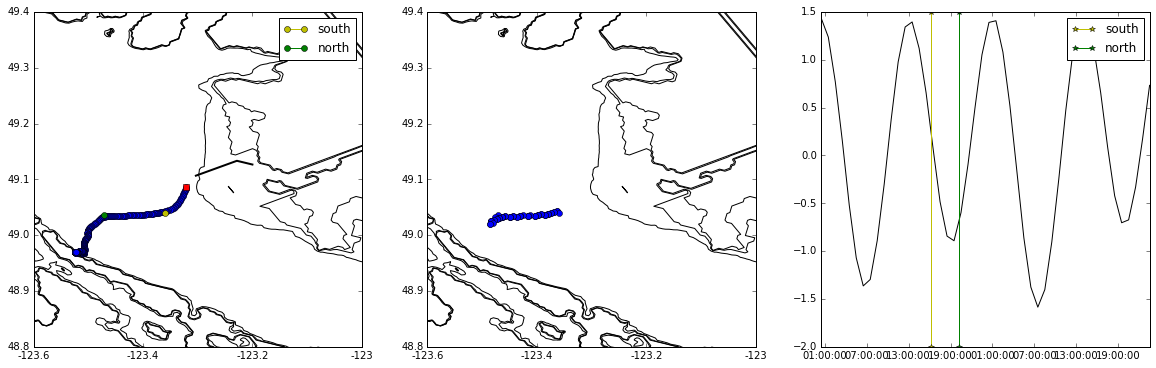

In [10]:
buoy = 0
name, tracks=drifter.organize_info(buoy,ubc)
print (name)
traj0=plot_buoy(tracks,dt.datetime(2014,10,8),i=-1)
fig, xs,ys,times = find_y_dist2(traj0,30,220)
v0 = Vvelocity2(xs,ys,times)

UBC-I-0001
Released 2014-10-08 16:00:06.999999 at 49.0862766667 , -123.320955 for 26.500277778055555 hours
NEMO coords: 425 287
V velocity is -8.10252547176  cm/s


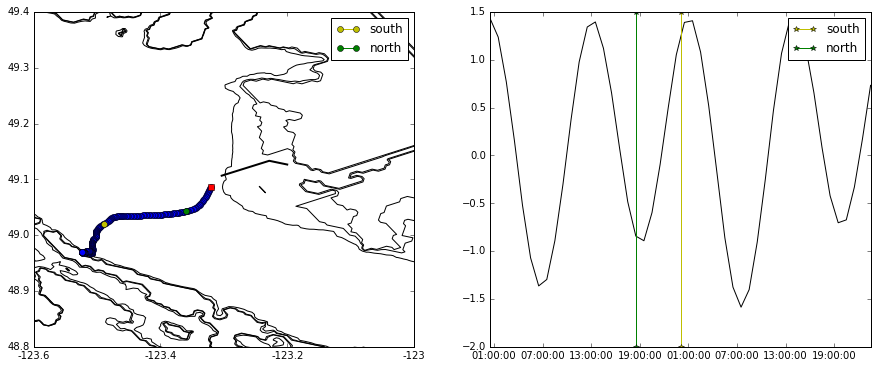

In [11]:
buoy = 0
name, tracks=drifter.organize_info(buoy,ubc)
print (name)
traj0=plot_buoy(tracks,dt.datetime(2014,10,8),i=-1)
fig, xs,ys,times = find_y_dist(traj0,30,220)
v0 = Vvelocity(ys,times)

# Buoy1

UBC-I-0002
Released 2014-10-08 16:05:07.999996 at 49.0956433333 , -123.320643333 for 26.499722222777777 hours
NEMO coords: 427 288
V velocity is 19.6529727509  cm/s


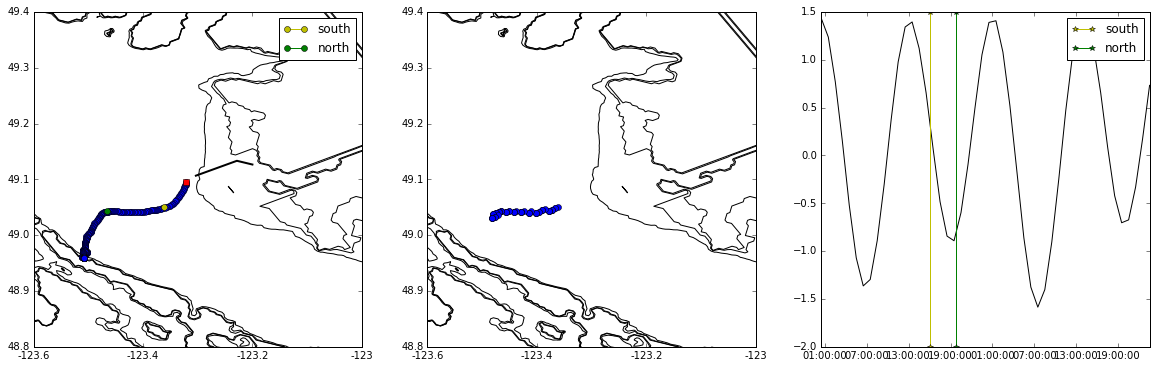

In [12]:
buoy = 1
name, tracks=drifter.organize_info(buoy,ubc)
print (name)
traj1=plot_buoy(tracks,dt.datetime(2014,10,8),i=-1)
fig, xs,ys,times = find_y_dist2(traj1,30,220)
v1 = Vvelocity2(xs,ys,times)

UBC-I-0002
Released 2014-10-08 16:05:07.999996 at 49.0956433333 , -123.320643333 for 26.499722222777777 hours
NEMO coords: 427 288
V velocity is -6.8081804843  cm/s


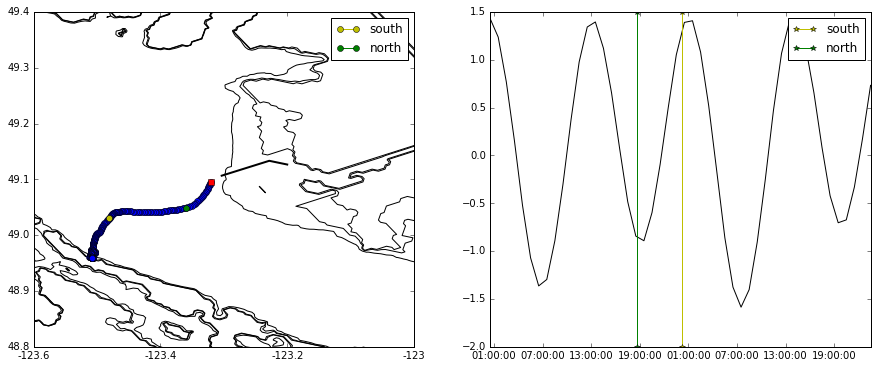

In [13]:
buoy = 1
name, tracks=drifter.organize_info(buoy,ubc)
print (name)
traj1=plot_buoy(tracks,dt.datetime(2014,10,8),i=-1)
fig, xs,ys,times = find_y_dist(traj1,30,220)
v1= Vvelocity(ys,times)

# Buoy2

UBC-I-0003
Released 2014-10-08 16:10:07.000003 at 49.1054983333 , -123.319833333 for 28.750277778333334 hours
NEMO coords: 429 290
V velocity is 45.560413999  cm/s


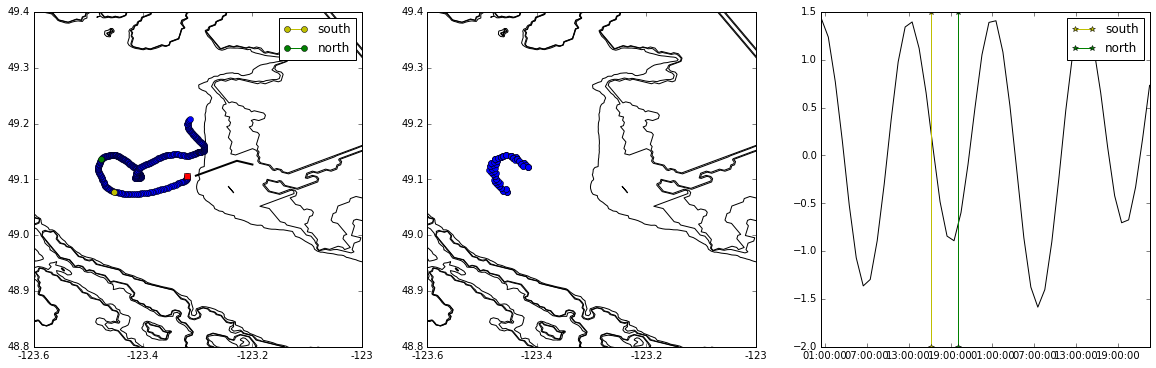

In [14]:
buoy = 2
name, tracks=drifter.organize_info(buoy,ubc)
print (name)
traj2=plot_buoy(tracks,dt.datetime(2014,10,8), i=-1)
fig, xs,ys,times = find_y_dist2(traj2,55,180)
v2 = Vvelocity2(xs,ys,times)

UBC-I-0003
Released 2014-10-08 16:10:07.000003 at 49.1054983333 , -123.319833333 for 28.750277778333334 hours
NEMO coords: 429 290
V velocity is 22.9829864376  cm/s


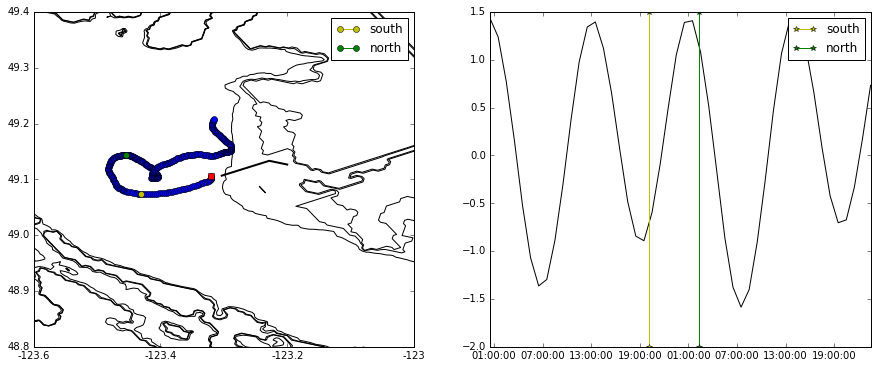

In [15]:
buoy = 2
name, tracks=drifter.organize_info(buoy,ubc)
print (name)
traj2=plot_buoy(tracks,dt.datetime(2014,10,8), i=-1)
fig, xs,ys,times = find_y_dist(traj2,40,220)
v2= Vvelocity(ys,times)

# Buoy3

UBC-I-0004
Released 2014-10-08 17:30:08.000004 at 49.1064116667 , -123.320053333 for 28.249999998055557 hours
NEMO coords: 429 290
V velocity is -13.3460235615  cm/s


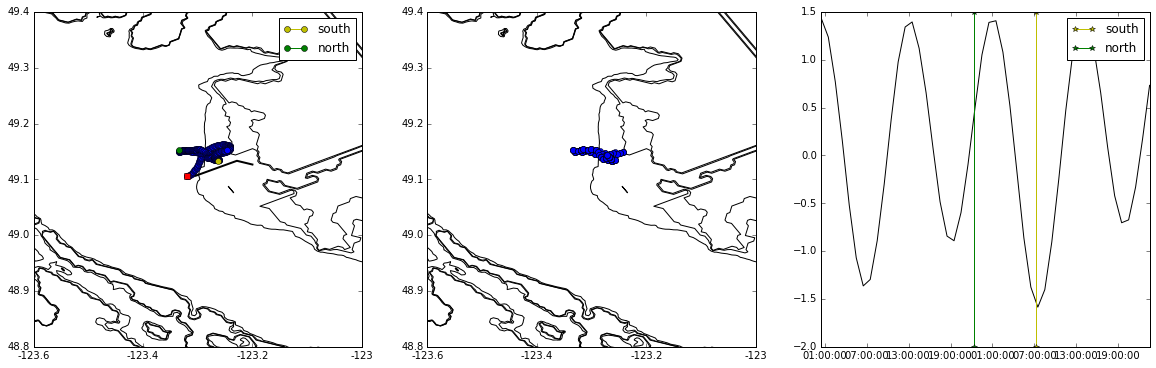

In [16]:
buoy = 3
name, tracks=drifter.organize_info(buoy,ubc)
print (name)
traj3=plot_buoy(tracks,dt.datetime(2014,10,8), i=-1)
fig, xs,ys,times = find_y_dist2(traj3,100,20)
v3 = Vvelocity2(xs,ys,times)

UBC-I-0004
Released 2014-10-08 17:30:08.000004 at 49.1064116667 , -123.320053333 for 28.249999998055557 hours
NEMO coords: 429 290
V velocity is 24.617309043  cm/s


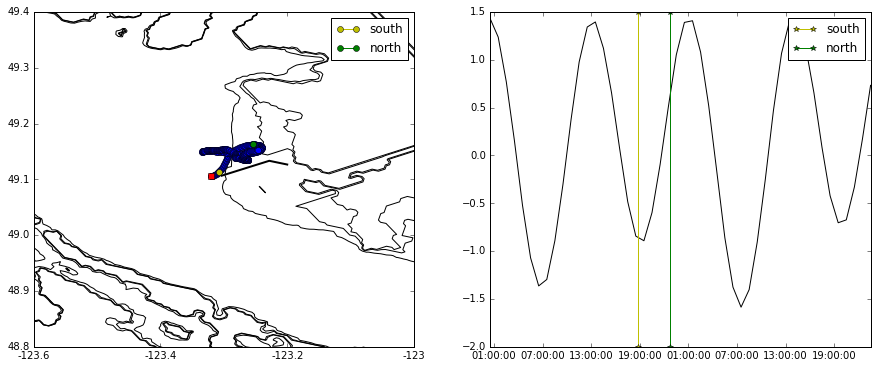

In [17]:
buoy = 3
name, tracks=drifter.organize_info(buoy,ubc)
print (name)
traj3=plot_buoy(tracks,dt.datetime(2014,10,8), i=-1)
fig, xs,ys,times = find_y_dist(traj3,15,200)
v3= Vvelocity(ys,times)

# Buoy4

UBC-I-0005
Released 2014-10-08 17:30:06.999999 at 49.0965066667 , -123.324513333 for 26.166944445 hours
NEMO coords: 427 289
V velocity is -33.7347226851  cm/s


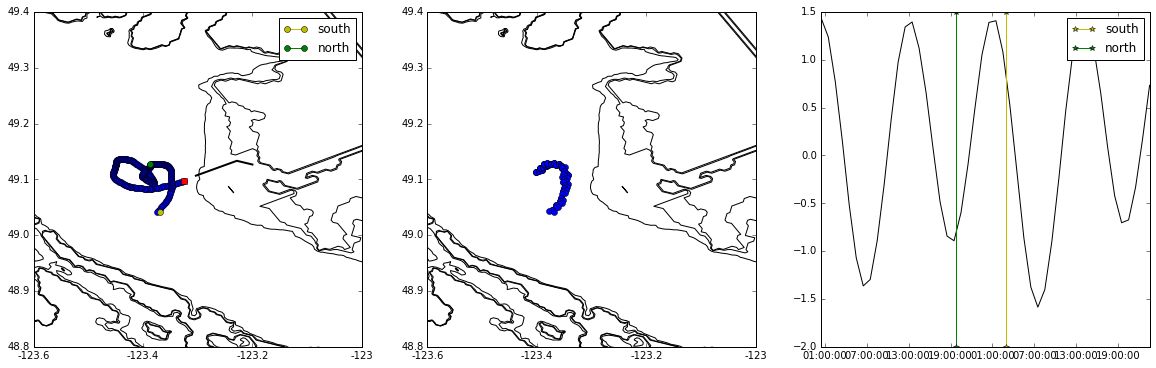

In [18]:
buoy = 4
name, tracks=drifter.organize_info(buoy,ubc)
print (name)
traj4=plot_buoy(tracks,dt.datetime(2014,10,8), i=-1)
fig, xs,ys,times = find_y_dist2(traj4,200,-1)
v4 = Vvelocity2(xs,ys,times)

UBC-I-0005
Released 2014-10-08 17:30:06.999999 at 49.0965066667 , -123.324513333 for 26.166944445 hours
NEMO coords: 427 289
V velocity is 16.1604517449  cm/s


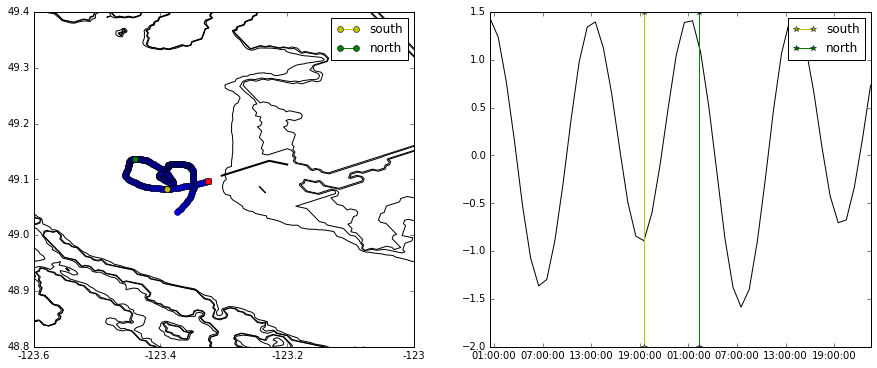

In [19]:
buoy = 4
name, tracks=drifter.organize_info(buoy,ubc)
print (name)
traj4=plot_buoy(tracks,dt.datetime(2014,10,8), i=-1)
fig, xs,ys,times = find_y_dist(traj4,15,200)
v4= Vvelocity(ys,times)

# Buoy5

UBC-I-0006
Released 2014-10-08 17:35:07.000001 at 49.08599 , -123.323693333 for 23.83333333222222 hours
NEMO coords: 425 287
V velocity is -18.0846695391  cm/s


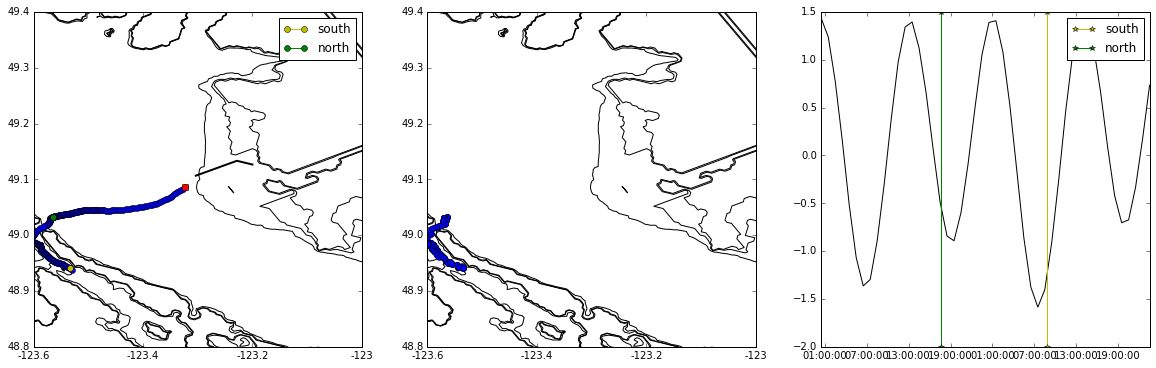

In [20]:
buoy = 5
name, tracks=drifter.organize_info(buoy,ubc)
print (name)
traj5=plot_buoy(tracks,dt.datetime(2014,10,8), i=-1)
fig, xs,ys,times = find_y_dist2(traj5,100,0)
v5 = Vvelocity2(xs,ys,times)

UBC-I-0006
Released 2014-10-08 17:35:07.000001 at 49.08599 , -123.323693333 for 23.83333333222222 hours
NEMO coords: 425 287
V velocity is -10.6320217815  cm/s
V velocity is -0.376469774847  cm/s


/home/jieliu/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:3: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


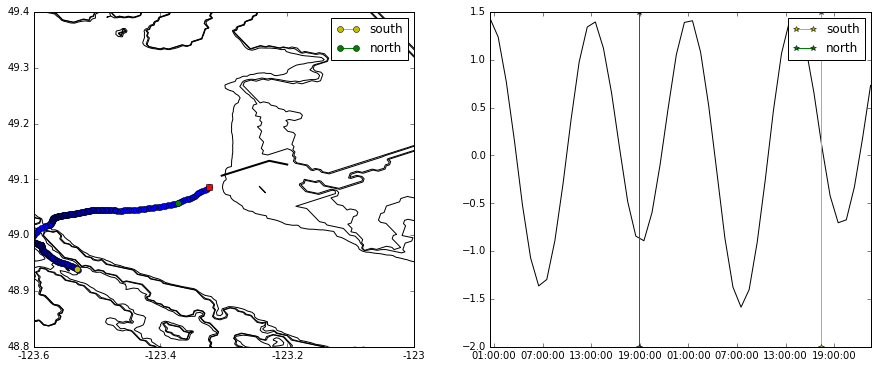

In [21]:
buoy = 5
name, tracks=drifter.organize_info(buoy,ubc)
print (name)
traj5=plot_buoy(tracks,dt.datetime(2014,10,8), i=-1)
fig, xs,ys,times = find_y_dist(traj5,15,0)
v5= Vvelocity(ys,times)
v5 = Vvelocity2(xs,ys,times)

# Buoy6

UBC-I-0007
Released 2014-10-08 19:10:07.999998 at 49.0856266667 , -123.325655 for 23.08361111111111 hours
NEMO coords: 425 287
V velocity is -8.70235402931  cm/s


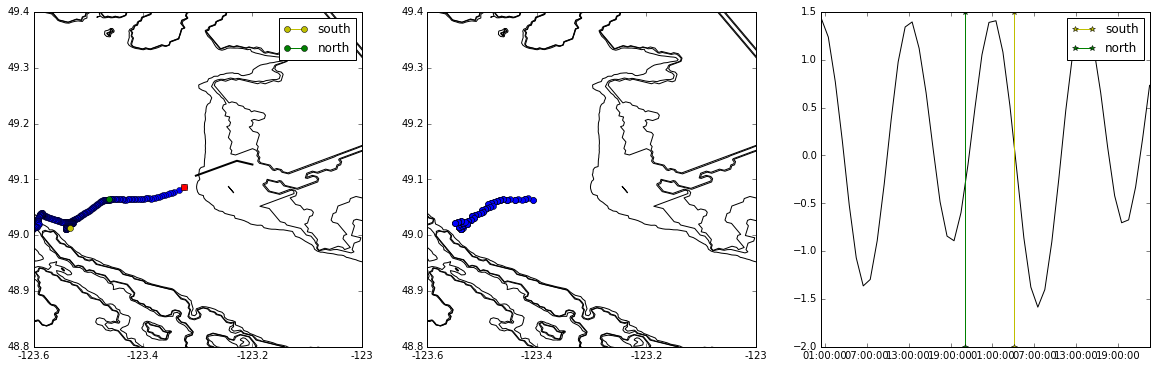

In [22]:
buoy = 6
name, tracks=drifter.organize_info(buoy,ubc)
print (name)
traj6=plot_buoy(tracks,dt.datetime(2014,10,8), i=-1)
fig, xs,ys,times = find_y_dist2(traj6,20,70)
v6 = Vvelocity2(xs,ys,times)

UBC-I-0007
Released 2014-10-08 19:10:07.999998 at 49.0856266667 , -123.325655 for 23.08361111111111 hours
NEMO coords: 425 287
V velocity is -14.5804787999  cm/s


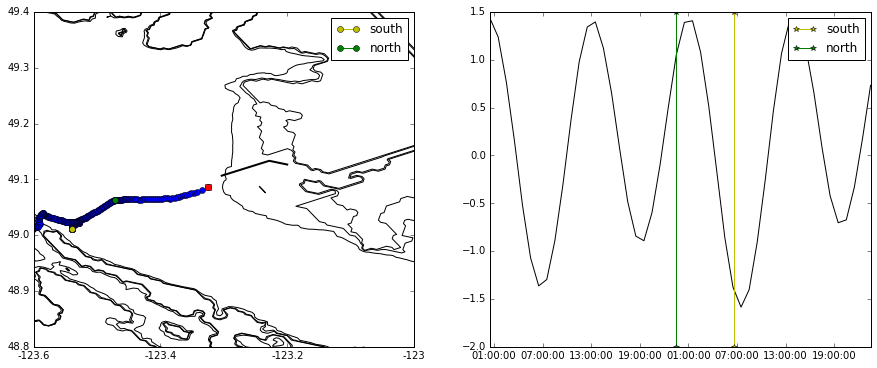

In [23]:
buoy = 6
name, tracks=drifter.organize_info(buoy,ubc)
print (name)
traj6=plot_buoy(tracks,dt.datetime(2014,10,8), i=-1)
fig, xs,ys,times = find_y_dist(traj6,50,0)
v6= Vvelocity(ys,times)

# Buoy7

UBC-I-0008
Released 2014-10-08 19:20:08.999997 at 49.0943266667 , -123.330828333 for 24.91638888888889 hours
NEMO coords: 427 287
V velocity is 36.7705185651  cm/s


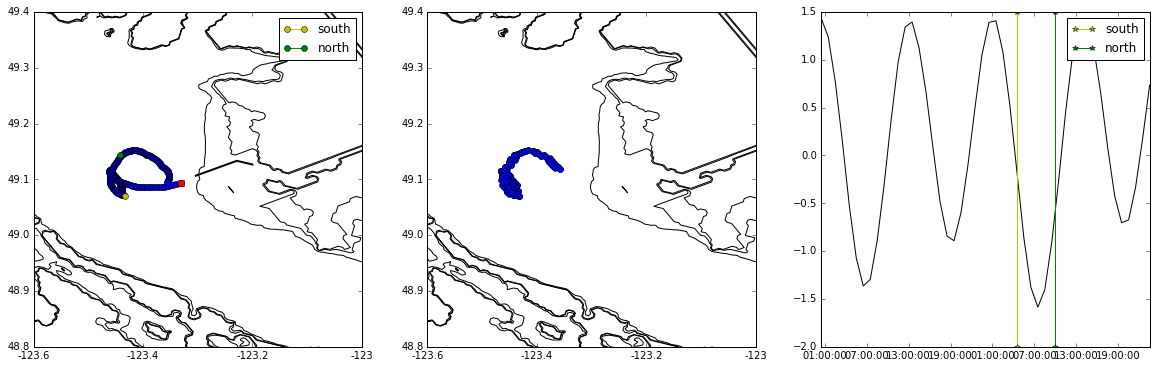

In [24]:
buoy = 7
name, tracks=drifter.organize_info(buoy,ubc)
print (name)
traj7=plot_buoy(tracks,dt.datetime(2014,10,8), i=-1)
fig, xs,ys,times = find_y_dist2(traj7,40,20)
v7 = Vvelocity2(xs,ys,times)

UBC-I-0008
Released 2014-10-08 19:20:08.999997 at 49.0943266667 , -123.330828333 for 24.91638888888889 hours
NEMO coords: 427 287
V velocity is 22.6685753418  cm/s


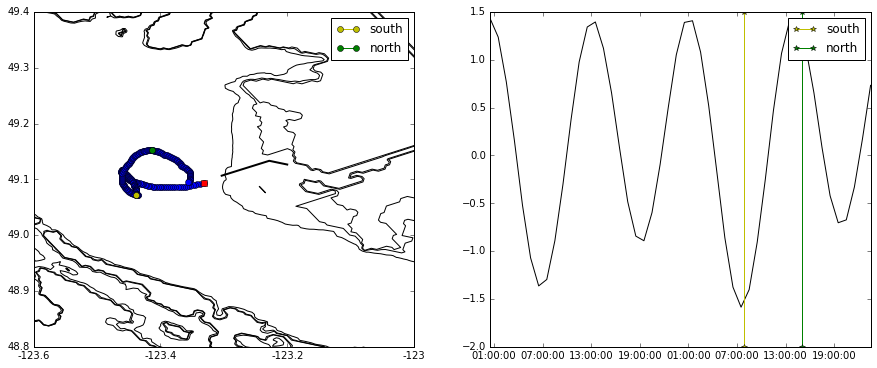

In [25]:
buoy = 7
name, tracks=drifter.organize_info(buoy,ubc)
print (name)
traj7=plot_buoy(tracks,dt.datetime(2014,10,8), i=-1)
fig, xs,ys,times = find_y_dist(traj7,15,0)
v7= Vvelocity(ys,times)

# Buoy9

UBC-I-0010
Released 2014-10-08 19:20:06.999998 at 49.1071733333 , -123.319563333 for 6.666666666111111 hours
NEMO coords: 429 290
V velocity is -6.19552925811  cm/s


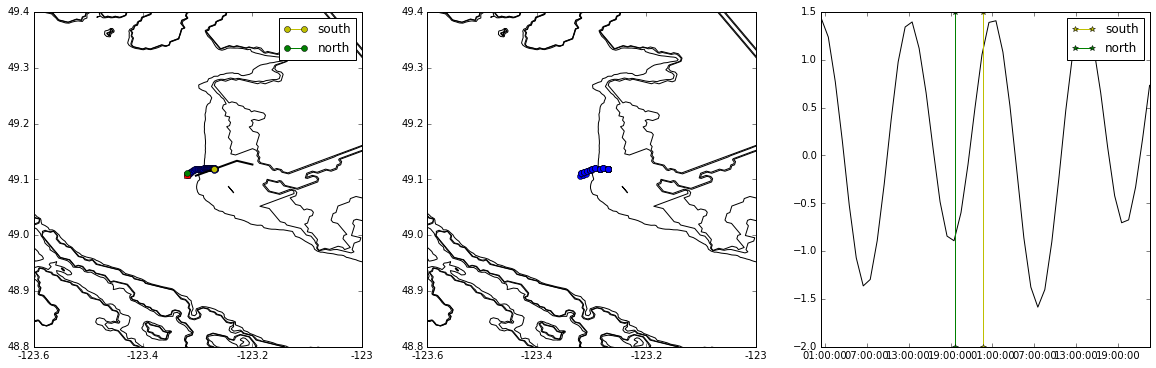

In [26]:
buoy = 9
name, tracks=drifter.organize_info(buoy,ubc)
print (name)
traj9=plot_buoy(tracks,dt.datetime(2014,10,8), i=-1)
fig, xs,ys,times = find_y_dist2(traj9,0,0)
v9 = Vvelocity2(xs,ys,times)

UBC-I-0010
Released 2014-10-08 19:20:06.999998 at 49.1071733333 , -123.319563333 for 6.666666666111111 hours
NEMO coords: 429 290
V velocity is 6.41092560173  cm/s


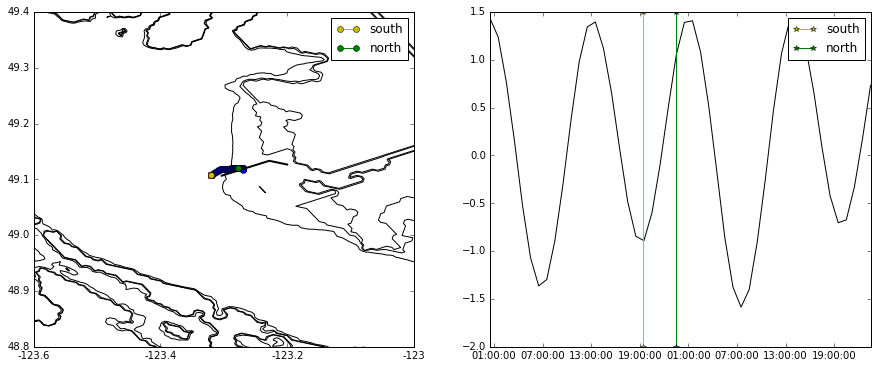

In [27]:
buoy = 9
name, tracks=drifter.organize_info(buoy,ubc)
print (name)
traj9=plot_buoy(tracks,dt.datetime(2014,10,8), i=-1)
fig, xs,ys,times = find_y_dist(traj9,0,0)
v9= Vvelocity(ys,times)